# Voltage Mode Buck with PPO deep reinforcement learning  

Implemented PPO reinforcement learning explained in following paper.  
https://www.mdpi.com/1996-1073/17/14/3578


## 📝Revisoin History

- **2025-06-10** Initial release.

- **2025-06-22** Optimization
  - Enabled Generalized Advantage Estimation (GAE) by setting `USE_GAE = True`.
  - Added new parameter generation function `generate_params_high_duty()` for testing high-duty conditions.
  - Modified the existing `generate_params_ccm_with_Lo()` to allow wider variation in `vin` and `vref`.
  - Changed actor network's output activation from `ReLU` to `Sigmoid` to constrain duty between 0 and 1.
  - Fixed incorrect critic model saving logic (was saving actor to critic file).
  - Added a new reward penalty term:
    - Penalizes excessive duty ratio values: `duty > 5 × Vref / Vin`
    - Applies strong penalty (`+50`) for violating this threshold.
  - Minor renaming: `values_mb → mb_values` for consistency.
  
- **2025-12-14** Updated the notebook to use the lowercase pytorch2ltspice module name and removed relative-path imports.

## 📁 Directories
```
BUCK_VM_PPO/
└── 1_train/
    ├── BUCK_VM_PPO_gym.asc             # LTspice schematics
    ├── sig_gen.asy                     # symbol file for signal generator
    ├── *sig_gen.sp                     # subcircuit file for signal generator (backup from last LTSpice simulation)
    ├── *BUCK_VM_PPO_param.txt          # Parameter file for LTspice simulation (backup from last LTSpice simulation)
    ├── *BUCK_VM_PPO_nn.sp              # Actor subcircuit file (backup from last LTSpice simulation)
    ├── *actor_final.pth                # Actor PyTorch model (backup from last LTSpice simulation)
    ├── *critic_final.pth               # Critic PyTorch model (backup from last LTSpice simulation)
    └── *gym                            # Working directly for the training
        ├── *log.csv                    # Log file of the simulation
        ├── *reward_plot.html           # Reward plot
        ├── *scatter_plot.html          # Scatter plot
        ├── *waveform_epXX.html         # Waveform plot
        ├── *BUKC_VM_PPO_param_epXX.txt # Parameter file for each episode
        ├── *BUKC_VM_PPO_nn_epXX.sp     # Actor subcircuit file for each episode
        ├── *actor_subckt_epXX.sp       # Actor model for each episode
        ├── *actor_epXX.pth             # Actor model for each episode
        └── *ciritic_epXX.pth           # Critic model for each episode
* Files/Directory created by this notebook.
```

## ⚔️ LTspice Training Circuit

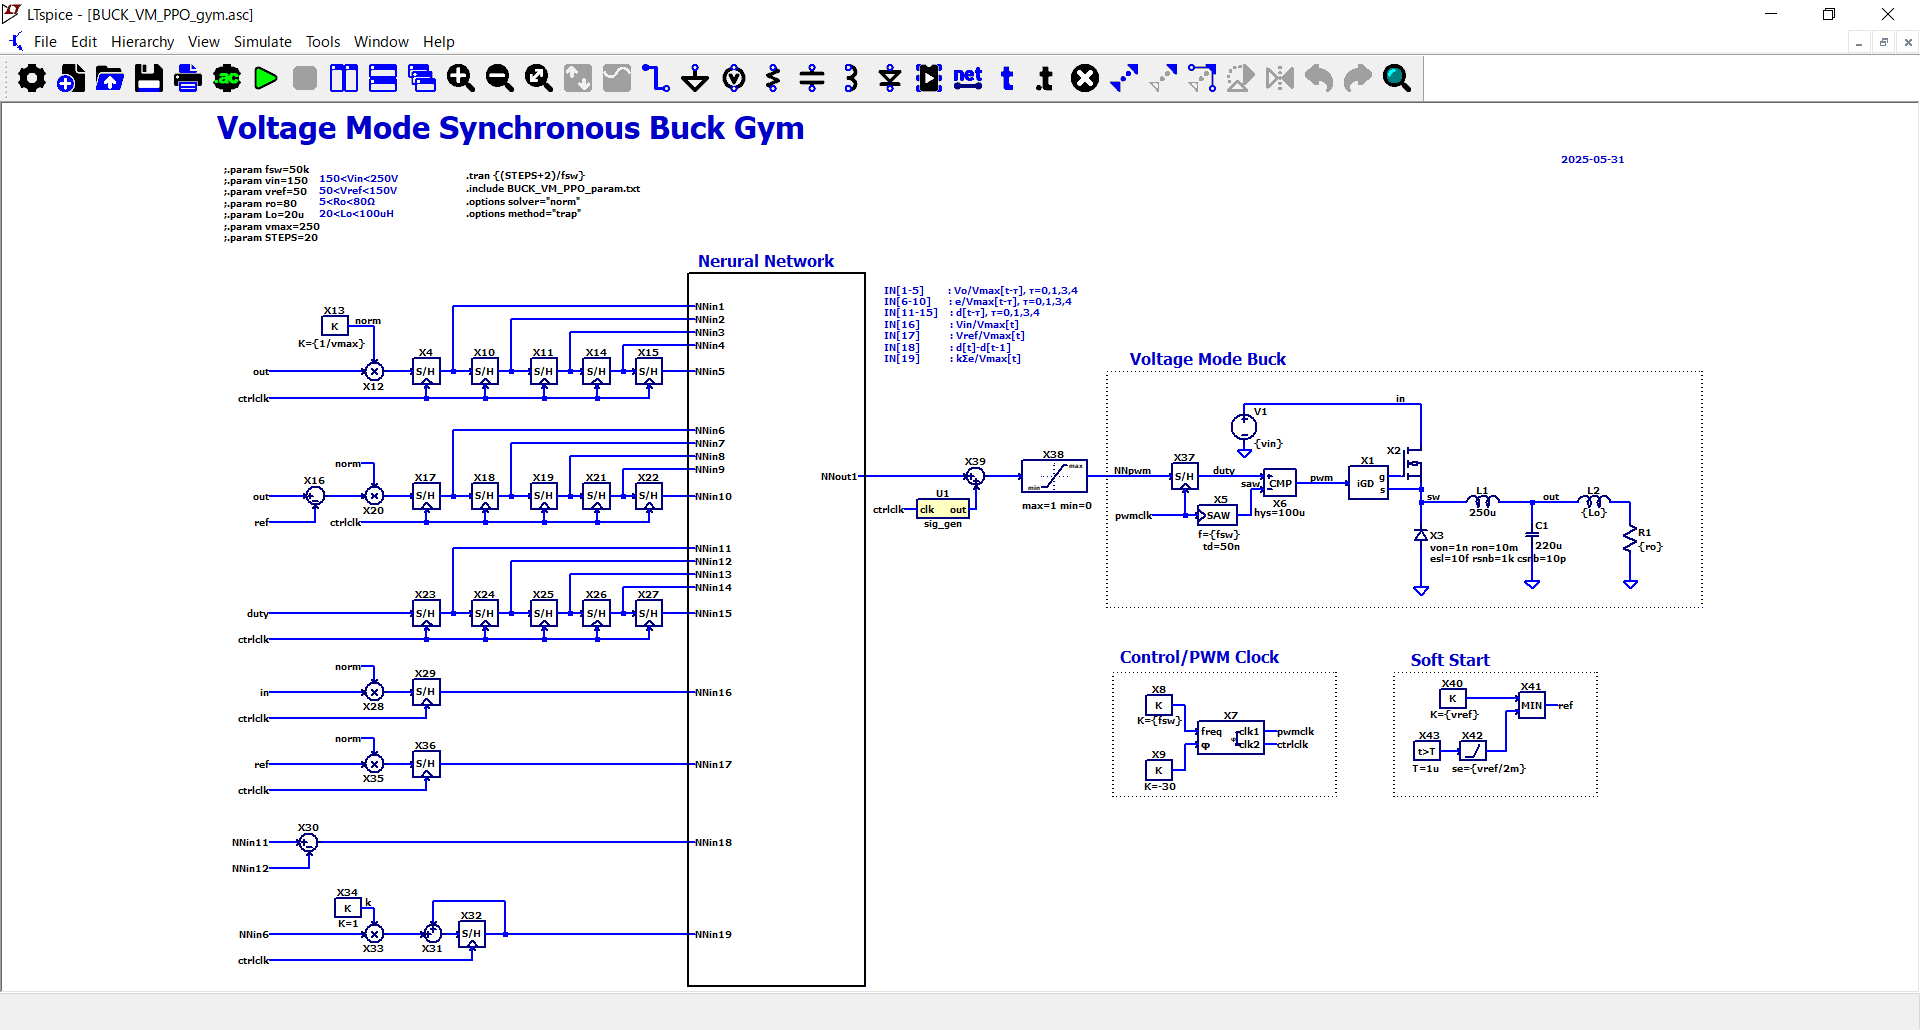

## 📗Import Libraries

In [1]:
import os
import shutil
import sys
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from PyLTSpice import SimRunner, RawRead, LTspice
from pytorch2ltspice import export_model_to_ltspice
from datetime import datetime
import plotly.graph_objects as go
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML

## ⚙️Configuration

In [ ]:
# Model IO count
NNIN=19
NNOUT=1

In [ ]:
# Hyperparameters
STEPS_PER_EPISODE = 2048    
BATCH_SIZE        = 256
EPOCH             = 10
GAMMA             = 0.9
USE_GAE           = True
GAE_LAMBDA        = 0.95
LR_ACTOR          = 1e-4
LR_CRITIC         = 1e-4
CLIP_EPS          = 0.2
ENT_COEF          = 0.001
SIM_TIMEOUT       = 600   #LTSPICE timeout time (sec)

In [ ]:
# Reward function parameters
ALPHA     = 7.0    # penalty when |error| ≥ EPS
BETA      = 1.0    # penalty when |error| < EPS
K_PENALTY = 1.0    # chattering penalty coefficient
EPSILON   = 0.01   # error threshold

In [ ]:
# File/Directory
ASCFILE = 'BUCK_VM_PPO_gym.asc'
NNFILE = 'BUCK_VM_PPO_nn.sp'
PARAMFILE = 'BUCK_VM_PPO_param.txt'
WORKDIR = './gym'
MODEL_ACTOR = 'actor_final.pth'
MODEL_CRITIC = 'critic_final.pth'
SGFILE = 'sig_gen.sp'
SGASYFILE = 'sig_gen.asy'
#create WORKDIR if it doesn't exist
os.makedirs(WORKDIR, exist_ok=True)

## 🧩Helping Functions

### Helping function to create parameter file

In [ ]:
def generate_param_file(params, filename):
    with open(filename, 'w', encoding='utf-8') as f:
        for name, value in params.items():
            f.write(f".param {name}={value}\n")
        f.write(f".include {NNFILE}\n")
        f.write("X99 NNin1 NNin2 NNin3 NNin4 NNin5 NNin6 NNin7 NNin8 NNin9 NNin10 NNin11 NNin12 NNin13 NNin14 NNin15 NNin16 NNin17 NNin18 NNin19 NNout1 ActorSubckt\n")
        f.write(".save V(ctrlclk) V(NNin1) V(NNin2) V(NNin3) V(NNin4) V(NNin5) V(NNin6) V(NNin7) V(NNin8) V(NNin9) V(NNin10) V(NNin11) V(NNin12) V(NNin13) V(NNin14) V(NNin15) V(NNin16) V(NNin17) V(NNin18) V(NNin19) V(NNout1) V(NNpwm)\n")


### Helfping Function to create signal generator subcircuit file

In [ ]:
def generate_siggen_subckt(signals, filename):
    N = len(signals)
    lines = []
    lines.append("* Auto‑generated SigGen subcircuit")
    lines.append(".SUBCKT sig_gen clk out")
    # --- build the chain: const → sum → samplehold (rising edge)
    lines.append("XX1 N001 const")
    lines.append("XX2 N001 cnt N002 sum")
    lines.append("XX3 clk N002 cnt samplehold")
    # --- behavioral table source: step through your d1..dN on V(cnt)==0,1,2,...
    #     starting at 0→0, then 1→d1, 2→d2, ..., N→dN
    table_args = ["0,0.0"]
    for i, v in enumerate(signals, start=1):
        table_args.append(f"{i},{v:.6f}")
    lines.append("B1 out 0 V=table(V(cnt), " + ", ".join(table_args) + ")")
    # --- now the three block definitions:
    lines += [
        "*--- const subcircuit: outputs DC K on its single pin ---",
        ".SUBCKT const K",
        "V1 K 0 {K}",
        ".PARAM K=1",
        ".ENDS const",
        "",
        "*--- sum subcircuit: adds two inputs ---",
        ".SUBCKT sum in1 in2 out",
        "B1 OUT 0 V=V(IN1)+V(IN2)",
        ".ENDS sum",
        "",
        "*--- samplehold subcircuit: latch on rising clk ---",
        ".SUBCKT samplehold CLK IN OUT",
        "R1 o 0 1k",
        "B1 OUT 0 V=V(o)",
        ".machine",
        ".state LO 0",
        ".state LATCH 1",
        ".state HI 2",
        ".rule LO LATCH V(CLK)>=.5",
        ".rule LATCH HI  V(CLK)>=.9",
        ".rule * LO V(CLK)<.5",
        ".output (o) IF((state==1),V(in),V(out))",
        ".endmachine",
        ".ENDS samplehold",
        ""
    ]
    # --- finally, export the param lines
    param_lines = [f".param d{i}={signals[i-1]:.6f}" for i in range(1, N+1)]
    lines += param_lines
    lines.append(".ENDS SigGen")
    lines.append("") 
    lines.append(".backanno")
    lines.append(".end")
    # write file
    with open(filename, "w", encoding="utf-8") as f:
        f.write("\n".join(lines))


Helping functions to create parameter

In [ ]:
def generate_params_random():
    return {
        'vin':  np.random.uniform(150, 250),
        'ro':   np.random.uniform(5, 80),
        'Lo':   np.random.uniform(20e-6, 100e-6),
        'vref': np.random.uniform(50, 150),
        'fsw':  50e3,
        'VMAX': 250,
        'STEPS': STEPS_PER_EPISODE
    }


In [ ]:
def generate_params_high_duty():
    min_duty=0.8
    vin=np.random.uniform(150, 150/min_duty-1)
    return {
        'vin':  vin,
        'ro':   np.random.uniform(5, 80),
        'Lo':   np.random.uniform(20e-6, 100e-6),
        'vref': np.random.uniform(vin*min_duty, 150),
        'fsw':  50e3,
        'VMAX': 250,
        'STEPS': STEPS_PER_EPISODE
    }


In [ ]:
def generate_params_ccm_with_Lo():
    return {
        'vin':  np.random.uniform(150, 250),
        'ro':   np.random.uniform(5, 40),
        'Lo':   np.random.uniform(50e-6, 100e-6),
        'vref': np.random.uniform(50, 150),
        'fsw':  50e3,
        'VMAX': 250,
        'STEPS': STEPS_PER_EPISODE
    }

In [ ]:
def generate_params_ccm_with_no_Lo():
    return {
        'vin':  np.random.uniform(150, 220),
        'ro':   np.random.uniform(5, 40),
        'Lo':   1e-9,
        'vref': np.random.uniform(80, 150),
        'fsw':  50e3,
        'VMAX': 250,
        'STEPS': STEPS_PER_EPISODE
    }

## 🧩Create Actor and Critic Networks
Loads .pth file if MODEL_ACTOR and/or MODEL_CRITIC files exists. Otherwise creates new network.

In [ ]:
class Actor(nn.Module):
    def __init__(self, input_dim=19, hidden1=32, hidden2=16, output_dim=1):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden1), nn.ReLU(),
            nn.Linear(hidden1, hidden2), nn.ReLU(),
            nn.Linear(hidden2, output_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

class Critic(nn.Module):
    def __init__(self, input_dim=19, hidden1=32, hidden2=16):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden1), nn.ReLU(),
            nn.Linear(hidden1, hidden2), nn.ReLU(),
            nn.Linear(hidden2, 1)
        )
    def forward(self, x):
        return self.model(x).squeeze(-1)

# Instantiate networks and optimizers
device = torch.device('cpu')
actor  = Actor().to(device)
critic = Critic().to(device)
opt_actor  = optim.Adam(actor.parameters(), lr=LR_ACTOR)
opt_critic = optim.Adam(critic.parameters(), lr=LR_CRITIC)

# Load saved models if available
if os.path.exists(MODEL_ACTOR):
    #actor.load_state_dict(torch.load(MODEL_ACTOR, map_location=device, weights_only=False))
    actor.load_state_dict(torch.load(MODEL_ACTOR, map_location=device))
    print(f"Loaded saved actor model from {MODEL_ACTOR}")
else:
    torch.save(actor.state_dict(), MODEL_ACTOR)
    print(f"Created new actor model and saved to {MODEL_ACTOR}")
if os.path.exists(MODEL_CRITIC):
    #critic.load_state_dict(torch.load(MODEL_CRITIC, map_location=device, weights_only=False))
    critic.load_state_dict(torch.load(MODEL_CRITIC, map_location=device))
    print(f"Loaded saved critic model from {MODEL_CRITIC}")
else:
    torch.save(critic.state_dict(), MODEL_CRITIC)
    print(f"Created new critic model and saved to {MODEL_CRITIC}")

## 🧩LTSpice execution routine 

Helping function to extract Status/Action data from .RAW file.
Stops data extraction once duty output gets out of range. 

In [ ]:
def extract_data(df, clk_col='V(ctrlclk)', nnout_col='V(nnout1)', threshold=0.5):
    clk = df[clk_col].values
    nnout = df[nnout_col].values

    # Check if the clock starts at high level
    if clk[0] > threshold:
        raise ValueError("Clock started with Level Hi")

    indices = []
    state = 'LOW'

    for i in range(1, len(clk)):
        if state == 'LOW' and clk[i - 1] <= threshold and clk[i] > threshold:
            state = 'HIGH'  # Rising edge detected
        elif state == 'HIGH' and clk[i - 1] > threshold and clk[i] <= threshold:
            # Falling edge detected
            indices.append(i)
            state = 'LOW'
            val = nnout[i]
            # If output sticks to 1.0, stop immediately
            if val>0.9999:
                break
            # If output sticks to 0.0 after 500 steps, stop
            if len(indices) > 500 and abs(val) < 1e-5:
                break
    df_falling_edges = df.iloc[indices].reset_index(drop=True)
    return df_falling_edges


LTspice execution

In [ ]:
def run_episode(actor, asc_file, work_dir):
    # 1) Create PyLTspice SimRunner instance
    runner = SimRunner(output_folder=work_dir, simulator=LTspice)
    netlist = runner.create_netlist(asc_file)
    
    # 2) Run simulation
    raw, log = runner.run_now(netlist, timeout=SIM_TIMEOUT)
    raw_data = RawRead(raw)
    df = raw_data.to_dataframe()
    df = extract_data(df)

    # 3) Extract states, actions
    states  = df[[f'V(nnin{i+1})' for i in range(19)]].values[:-1]         # S[t]
    actions = df['V(nnpwm)'].values[:-1]                                   # A[t]

    # 4) Reward calculation
    enorm   = df['V(nnin6)'].shift(-1).values[:-1]                         # e[t+1]
    ed      = (df['V(nnin18)'].shift(-1).values**2)[:-1]                   # (d[t+1]-d[t])^2
    rewards = np.where(
        np.abs(enorm) < EPSILON,
        -BETA * np.abs(enorm) - K_PENALTY * ed,
        -ALPHA * np.abs(enorm) - K_PENALTY * ed
    )


    # Additional penalty: when duty exceeds 5 × Vout / Vin
    duty_penalty = np.zeros_like(actions)
    vref = df['V(nnin17)'].values[:-1]          # Target output voltage
    vin  = df['V(nnin16)'].values[:-1]          # Input voltage
    duty_threshold = 5 * vref / (vin + 1e-6)    # Prevent division by zero
    # Apply penalty if duty is excessively high (i.e., > 5 × Vref / Vin)
    penalty_mask = actions > duty_threshold
    duty_penalty[penalty_mask] = 50.0           # Penalty coefficient (tunable)
    rewards -= duty_penalty

    # 5) Crean PyLTspice files
    runner.cleanup_files()

    return states, actions, rewards, df

## 🧩PPO Update Step

In [ ]:
def ppo_update(states, actions, rewards, noise_std, batch_size=64, epochs=10):
    # 0) Convert to tensors
    states_t  = torch.tensor(states,  dtype=torch.float32, device=device)
    actions_t = torch.tensor(actions, dtype=torch.float32, device=device).unsqueeze(-1)
    rewards_t = torch.tensor(rewards, dtype=torch.float32, device=device)

    # 1) Compute log probability of old policy
    with torch.no_grad():
        actions_py = actor(states_t).cpu().numpy().squeeze()
        dist_old = torch.distributions.Normal(actor(states_t), noise_std)
        old_log_probs = dist_old.log_prob(actions_t).squeeze(-1)

    # 2) Estimate values from critic
    with torch.no_grad():
        values = critic(states_t).squeeze(-1)
        next_values = torch.cat([values[1:], values[-1:]])  # bootstrapped last (for GAE only)

    # 3) Compute returns and advantages
    if USE_GAE:
        deltas = rewards_t + GAMMA * next_values - values
        advantages = torch.zeros_like(rewards_t)
        adv = 0.0
        for t in reversed(range(len(rewards_t))):
            adv = deltas[t] + GAMMA * GAE_LAMBDA * adv
            advantages[t] = adv
        returns = advantages + values
    else:
        returns = torch.zeros_like(rewards_t)
        G = 0.0
        for t in reversed(range(len(rewards_t))):
            G = rewards_t[t] + GAMMA * G
            returns[t] = G
        advantages = returns - values

    # Normalize advantages
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

    # 4) Train for multiple epochs
    dataset_size = states_t.size(0)
    for epoch in range(epochs):
        for start in range(0, dataset_size, batch_size):
            end = min(start + batch_size, dataset_size)
            mb_states      = states_t[start:end]
            mb_actions     = actions_t[start:end]
            mb_old_log_probs = old_log_probs[start:end]
            mb_returns     = returns[start:end]
            mb_advantages  = advantages[start:end]

            # Critic loss
            mb_values = critic(mb_states).squeeze(-1)
            loss_critic = nn.MSELoss()(mb_values, mb_returns)

            # Actor loss (PPO-clip)
            dist_new = torch.distributions.Normal(actor(mb_states), noise_std)
            log_probs_new = dist_new.log_prob(mb_actions).squeeze(-1)
            ratios = torch.exp(log_probs_new - mb_old_log_probs)
            surr1 = ratios * mb_advantages
            surr2 = torch.clamp(ratios, 1.0 - CLIP_EPS, 1.0 + CLIP_EPS) * mb_advantages
            loss_actor = -torch.min(surr1, surr2).mean() - ENT_COEF * log_probs_new.mean()

            # Backpropagation
            opt_actor.zero_grad()
            loss_actor.backward()
            opt_actor.step()

            opt_critic.zero_grad()
            loss_critic.backward()
            opt_critic.step()

    return (
        dataset_size,
        loss_actor.item(),
        loss_critic.item(),
        actions_py,
        values.detach().cpu().numpy(),
        returns.detach().cpu().numpy(),
        advantages.detach().cpu().numpy()
    )

## 📉Training Status Plot 

In [ ]:
fig_reward = go.FigureWidget()
fig_reward.add_trace(go.Scatter(x=[], y=[], mode='lines+markers', name='Average Reward', yaxis='y1'))
fig_reward.add_trace(go.Scatter(x=[], y=[], mode='lines+markers', name='Noise Std', yaxis='y2'))
fig_reward.add_trace(go.Scatter(x=[], y=[], mode='lines+markers', name='Steps', yaxis='y2'))
fig_reward.update_layout(xaxis=dict(title='Episode'), yaxis=dict(title='Average Reward'), yaxis2=dict(title='Noise Std', overlaying='y', side='right'), legend=dict(x=0, y=1.2, orientation='h'))

fig_scatter = go.FigureWidget()
fig_scatter.add_trace(go.Scatter(x=[], y=[], mode='markers', marker=dict(size=10, color=[], colorscale='Viridis', colorbar=dict(title='Reward'), showscale=True),text=[], hoverinfo='text'))
fig_scatter.update_layout(title='Vout/Vin vs Iout/Icrit (Colored by Average Reward)', xaxis_title='Iout/Icrit', yaxis_title='Vout/Vin')

fig_nn = go.FigureWidget()
fig_nn.add_trace(go.Scatter(x=[], y=[], name='nnin1(Vo/Vmax)', yaxis='y1', mode='lines+markers'))
fig_nn.add_trace(go.Scatter(x=[], y=[], name='nnin17(Vref/Vmax)', yaxis='y1', mode='lines'))
fig_nn.add_trace(go.Scatter(x=[], y=[], name='nnpwm(nnout1+noise)', yaxis='y1', mode='lines+markers'))
fig_nn.add_trace(go.Scatter(x=[], y=[], name='nnout1', yaxis='y1', mode='lines+markers'))
fig_nn.add_trace(go.Scatter(x=[], y=[], name='nnout1(python)', yaxis='y1', mode='lines+markers'))
fig_nn.add_trace(go.Scatter(x=[], y=[], name='rewards', yaxis='y2', mode='lines+markers'))
fig_nn.add_trace(go.Scatter(x=[], y=[], name='values', yaxis='y2', mode='lines+markers'))
fig_nn.add_trace(go.Scatter(x=[], y=[], name='returns', yaxis='y2', mode='lines+markers'))
fig_nn.add_trace(go.Scatter(x=[], y=[], name='advantages', yaxis='y2', mode='lines+markers'))
fig_nn.update_layout(xaxis=dict(title='Step'), yaxis=dict(title='NNIO'), yaxis2=dict(title='Rewards', overlaying='y', side='right'))
fig_nn.update_layout(legend=dict(orientation="h", x=0.5, y=-0.3, xanchor='center', yanchor='top'),height=500)
t = list(range(STEPS_PER_EPISODE)) 
for i in range(9):
    fig_nn.data[i].x = t

fig_nn2 = go.FigureWidget()
fig_nn2.add_trace(go.Scatter(x=[], y=[], name='nnin1', yaxis='y1', mode='lines+markers'))
fig_nn2.add_trace(go.Scatter(x=[], y=[], name='nnin17', yaxis='y1', mode='lines'))
fig_nn2.add_trace(go.Scatter(x=[], y=[], name='nnpwm', yaxis='y1', mode='lines+markers'))
fig_nn2.add_trace(go.Scatter(x=[], y=[], name='nnout1', yaxis='y1', mode='lines'))
fig_nn2.add_trace(go.Scatter(x=[], y=[], name='rewards', yaxis='y2', mode='lines+markers'))
fig_nn2.update_layout(xaxis=dict(title='Step'), yaxis=dict(title='NNIO'), yaxis2=dict(title='Rewards', overlaying='y', side='right'), legend=dict(x=0, y=1.2, orientation='h'))
t = list(range(STEPS_PER_EPISODE)) 
for i in range(5):
    fig_nn2.data[i].x = t


## ♻️Training Loop

In [ ]:
#reload or newly create log.csv
if os.path.exists("./gym/log.csv"):
    summary_df = pd.read_csv("./gym/log.csv") 
else:
    summary_df = pd.DataFrame(columns=['episode','sim time','avg_reward','loss_actor','loss_critic','vin','ro','Lo','vref','fsw','std','steps','batch','epoch','Vout/Vin','Iout/Icrit'])


def train_loop(base_ep, num_ep, noise_stds, param_fn):        
    # Remove episode data from summary_df from base_ep onwards
    global summary_df
    summary_df = summary_df[summary_df['episode'] < base_ep].reset_index(drop=True)

    # Main loop
    for ep in range(base_ep , base_ep+num_ep):
        try:
            sim_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
            print(f">>> {sim_time}")

            # 1) Save actor/critic files
            torch.save(actor.state_dict(), WORKDIR+f"/actor_ep{ep}.pth")
            torch.save(critic.state_dict(), WORKDIR+f"/critic_ep{ep}.pth")
            torch.save(actor.state_dict(), MODEL_ACTOR)
            torch.save(critic.state_dict(), MODEL_CRITIC)


            # 2) Export current actor to SPICE subckt
            export_model_to_ltspice(actor.model, filename=NNFILE, subckt_name='ActorSubckt', verbose=False)
            shutil.copy2(NNFILE, WORKDIR)
            name, ext = os.path.splitext(NNFILE)   
            shutil.copy2(NNFILE, f"{WORKDIR}/{name}_ep{ep}{ext}")   

            # 3) Generate a new noise sequence and create SigGen subckt
            noise_std = noise_stds[ep-1]
            noises = np.random.normal(loc=0.0, scale=noise_std, size=STEPS_PER_EPISODE)
            generate_siggen_subckt(signals=noises, filename=SGFILE)
            shutil.copy2(SGFILE, WORKDIR)
            name, ext = os.path.splitext(SGFILE)   
            shutil.copy2(SGFILE, f"{WORKDIR}/{name}_ep{ep}{ext}")   
            shutil.copy2(SGASYFILE, WORKDIR)
            
            # 4) Generate Parameter file
            params = param_fn()
            generate_param_file(params, PARAMFILE)
            shutil.copy2(PARAMFILE, WORKDIR)
            name, ext = os.path.splitext(PARAMFILE)   
            shutil.copy2(PARAMFILE, f"{WORKDIR}/{name}_ep{ep}{ext}")   
            
            # 5) Run one full episode in LTspice
            vout_vin = params['vref'] / params['vin']
            iout_icrit = params['vref'] / params['ro'] / (0.5 * params['vref'] * (params['vin'] - params['vref']) / params['fsw'] / 0.0002 / params['vin'])
            print(f"[Ep{ep}/{base_ep+num_ep-1}] Vout/Vin:{vout_vin:.2f}, Iout/Icrit:{iout_icrit:.3f}, std:{noise_std:.4f}")   #L=200uH
            states, actions, rewards, df= run_episode(actor, ASCFILE, WORKDIR)

            # 6) Perform PPO update with collected data
            dataset_size, loss_actor, loss_critic, actions_py, values, returns, advantages = ppo_update(states, actions, rewards, noise_std, batch_size=BATCH_SIZE, epochs=EPOCH)

            # 7) Compute and print summary statistics
            avg_reward = np.mean(rewards)
            print(f"[Ep{ep}/{base_ep+num_ep-1}]",
                f"Average Reward: {avg_reward:.3f}, "
                f"Loss_actor: {loss_actor:.3f}, "
                f"Loss_critic: {loss_critic:.3f}")

            # 8) Update&Save episode graph
            fig_nn.data[0].y = df['V(nnin1)']
            fig_nn.data[1].y = df['V(nnin17)']
            fig_nn.data[2].y = df['V(nnpwm)']
            fig_nn.data[3].y = df['V(nnout1)']
            fig_nn.data[4].y = actions_py
            fig_nn.data[5].y = rewards
            fig_nn.data[6].y = values
            fig_nn.data[7].y = returns
            fig_nn.data[8].y = advantages
            fig_nn.update_layout(title_text=f"Ep{ep}: Vout/Vin={vout_vin:.2f}, Iout/Icrit={iout_icrit:.2f}, std={noise_stds[ep]:.4f}")
            fig_nn2.data[0].y = df['V(nnin1)']
            fig_nn2.data[1].y = df['V(nnin17)']
            fig_nn2.data[2].y = df['V(nnpwm)']
            fig_nn2.data[3].y = df['V(nnout1)']
            fig_nn2.data[4].y = rewards
            fig_nn2.update_layout(title_text=f"Ep{ep}: Vout/Vin={vout_vin:.2f}, Iout/Icrit={iout_icrit:.2f}, std={noise_stds[ep]:.4f}")
            html_path = WORKDIR + f"/waveform_ep{ep}.html"
            fig_nn2.write_html(html_path, include_plotlyjs='cdn')

            # 9) Append summary
            summary_df.loc[len(summary_df)] = {
                'episode':      ep,
                'sim time':     sim_time,
                'avg_reward':   avg_reward,
                'loss_actor':   loss_actor,
                'loss_critic':  loss_critic,
                'vin':          params['vin'],
                'ro':           params['ro'],
                'Lo':           params['Lo'],
                'vref':         params['vref'],
                'fsw':          params['fsw'],
                'std':          noise_std,
                'steps':        dataset_size,
                'batch':        BATCH_SIZE,
                'epoch':        EPOCH,
                'Vout/Vin':     vout_vin,
                'Iout/Icrit':   iout_icrit
            }

            # 10) Update/Save learning curve plot
            fig_reward.data[0].x = summary_df['episode']
            fig_reward.data[0].y = summary_df['avg_reward']
            fig_reward.data[1].x = summary_df['episode']
            fig_reward.data[1].y = summary_df['std']
            fig_reward.data[2].x = summary_df['episode']
            fig_reward.data[2].y = summary_df['steps']
            reward_html_path = os.path.join(WORKDIR, "reward_plot.html")
            fig_reward.write_html(reward_html_path, include_plotlyjs='cdn')

            # 11) Update/Save Scatter plot
            fig_scatter.data[0].x = summary_df['Iout/Icrit']
            fig_scatter.data[0].y = summary_df['Vout/Vin']
            fig_scatter.data[0].marker.color = summary_df['avg_reward']
            fig_scatter.data[0].text = summary_df['episode']
            scatter_html_path = os.path.join(WORKDIR, "scatter_plot.html")
            fig_scatter.write_html(scatter_html_path, include_plotlyjs='cdn')

            # 12) Save summary to CSV
            episode_csv = os.path.join(WORKDIR, 'log.csv')
            summary_df.to_csv(episode_csv, index=False)    

            # 13) Save actor/critic files
            torch.save(actor.state_dict(), MODEL_ACTOR)
            torch.save(critic.state_dict(), MODEL_CRITIC)

        except Exception as e:
            print(f"[Ep{ep}/{base_ep+num_ep-1}] ERROR: Failed with exception: {e}")
            continue



Function to revert Actor/Critic model

In [ ]:
def revert_to(ep):

    # 1) Copy & Load .pth files
    file_missing=False
    if not os.path.isfile(WORKDIR+f"/actor_ep{ep}.pth"):
        file_missing = True
    if not os.path.isfile(WORKDIR+f"/critic_ep{ep}.pth"):
        file_missing = True
    if file_missing:
        print(f"[Error].pth file for ep{ep} file did not exist.")    
    else:
        shutil.copy2(WORKDIR+f"/actor_ep{ep}.pth", MODEL_ACTOR)
        actor.load_state_dict(torch.load(MODEL_ACTOR, map_location=device))
        print(f"copy & loaded {WORKDIR}/actor_ep{ep}.pth to ./{MODEL_ACTOR}")
        shutil.copy2(WORKDIR+f"/critic_ep{ep}.pth", MODEL_CRITIC)
        critic.load_state_dict(torch.load(MODEL_CRITIC, map_location=device))
        print(f"copy & loaded {WORKDIR}/critic_ep{ep}.pth to ./{MODEL_CRITIC}")


    # 2) Copy simulation files for the episode
    # 2-1) Parameter file
    name, ext = os.path.splitext(PARAMFILE)
    param_path = f"{WORKDIR}/{name}_ep{ep}{ext}"
    if os.path.isfile(param_path):
        shutil.copy2(param_path, PARAMFILE)
        print(f"copied {param_path} to ./{PARAMFILE}")
    
    # 2-2) Noise subcircuit 
    name, ext = os.path.splitext(SGFILE)
    sg_path = f"{WORKDIR}/{name}_ep{ep}{ext}"
    if os.path.isfile(sg_path):
        shutil.copy2(sg_path, SGFILE)
        print(f"copied {sg_path} to ./{SGFILE}")

    # 2-3) Actor subcircuit
    name, ext = os.path.splitext(NNFILE)
    nn_path = f"{WORKDIR}/{name}_ep{ep}{ext}"
    if os.path.isfile(nn_path):
        shutil.copy2(nn_path, NNFILE)
        print(f"copied {nn_path} to ./{NNFILE}")
    


##  🧠Training Display

In [ ]:
display(fig_reward)
display(fig_scatter)
display(fig_nn)

##  🧠Training Steps(Example)

In [ ]:
INITIAL_STD = 0.3
MIN_STD = 0.1
NUM_EPISODES = 200
noise_stds = [max(MIN_STD, INITIAL_STD * (1 - ep / NUM_EPISODES)) for ep in range(NUM_EPISODES)]
train_loop(1,200,noise_stds, generate_params_random)

In [ ]:
noise_stds += [0.05 for _ in range(0, 100)]
train_loop(201,50,noise_stds, generate_params_high_duty)